In [1]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
import seaborn as sns 
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

warnings.filterwarnings('ignore')
%matplotlib inline
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

Using TensorFlow backend.


In [2]:
os.getcwd()

'/Users/user/projects/kaggle/KGGS/State-Farm-Distracted-Driver-Detection/kernels/CNN-to-detect-driver-actions'

In [3]:
DATA_IN_PATH = os.getcwd() + '/data/'
file_list = ['state-farm-distracted-driver-detection.zip']

for file in file_list:
    zipRef = zipfile.ZipFile(DATA_IN_PATH + file, 'r')
    zipRef.extractall(DATA_IN_PATH)
    zipRef.close

In [3]:
dataset = pd.read_csv(os.getcwd() + '/data/driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [5]:
dataset['subject'].unique()

array(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
       'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
       'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
       'p075', 'p081'], dtype=object)

In [6]:
dataset['classname'].unique()

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
      dtype=object)

In [7]:
# Load the dataset previously downloaded from Kaggle
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.getcwd() + '/data/imgs/train/c' + str(classed) + '/*.jpg')
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)  # one hot encode integer data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type) # GRAYSCALE일 때 Shape 맞추기 위함
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    files = sorted(glob(os.getcwd() + '/data/imgs/test/*.jpg'))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    test_data = np.array(test_data, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

- tqdm
- cv2
  - cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.
  - cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.
  - cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.
  - BGR
- dtype=np.uint8
  - 0 ~ 255 (2^8개만 표현 가능)

In [8]:
img_rows = 64
img_cols = 64
color_type = 1

In [10]:
path = os.getcwd() + '/data/imgs/train/c0/img_100026.jpg'

In [11]:
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img.shape

(480, 640)

In [12]:
img = cv2.imread(path, cv2.IMREAD_COLOR)
img.shape

(480, 640, 3)

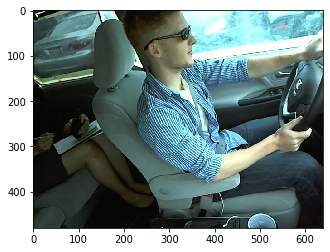

In [13]:
image = mpimg.imread(path)
plt.imshow(image)

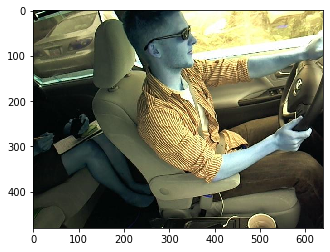

In [14]:
plt.imshow(cv2.imread(path, cv2.IMREAD_UNCHANGED))

In [15]:
b, g, r = cv2.split(img)   # img파일을 b,g,r로 분리
img2 = cv2.merge([r,g,b]) # b, r을 바꿔서 Merge

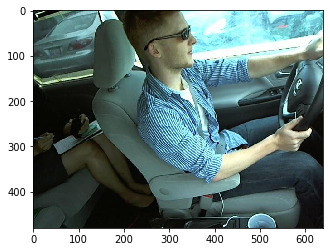

In [16]:
plt.imshow(img2)

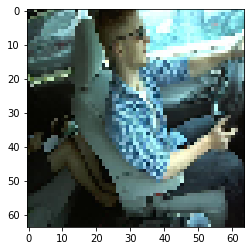

In [17]:
img = cv2.resize(image, (img_rows, img_cols), interpolation=cv2.INTER_LINEAR)
plt.imshow(img)

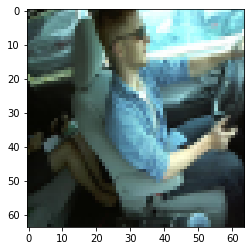

In [18]:
img = cv2.resize(image, (img_rows, img_cols), interpolation=cv2.INTER_AREA)
plt.imshow(img)

In [20]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:05<00:51,  5.76s/it]

Loading directory c1


 20%|██        | 2/10 [00:11<00:45,  5.68s/it]

Loading directory c2


 30%|███       | 3/10 [00:17<00:40,  5.78s/it]

Loading directory c3


 40%|████      | 4/10 [00:22<00:33,  5.52s/it]

Loading directory c4


 50%|█████     | 5/10 [00:26<00:26,  5.31s/it]

Loading directory c5


 60%|██████    | 6/10 [00:31<00:20,  5.15s/it]

Loading directory c6


 70%|███████   | 7/10 [00:36<00:15,  5.07s/it]

Loading directory c7


 80%|████████  | 8/10 [00:40<00:09,  4.82s/it]

Loading directory c8


 90%|█████████ | 9/10 [00:44<00:04,  4.56s/it]

Loading directory c9


100%|██████████| 10/10 [00:49<00:00,  4.94s/it]

Data Loaded in 49.356502056121826 second
Train shape: (17939, 64, 64, 1)
17939 train samples


In [21]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|          | 185/79726 [00:00<03:07, 423.40it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


Statistics

In [22]:
# Statistics
# Load the list of names
test_files_size = len(np.array(glob(os.getcwd() + '/data/imgs/test/*.jpg')))
x_train_size = len(x_train)
categories_size = len(dataset['classname'].unique())
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


Dataset Visualization

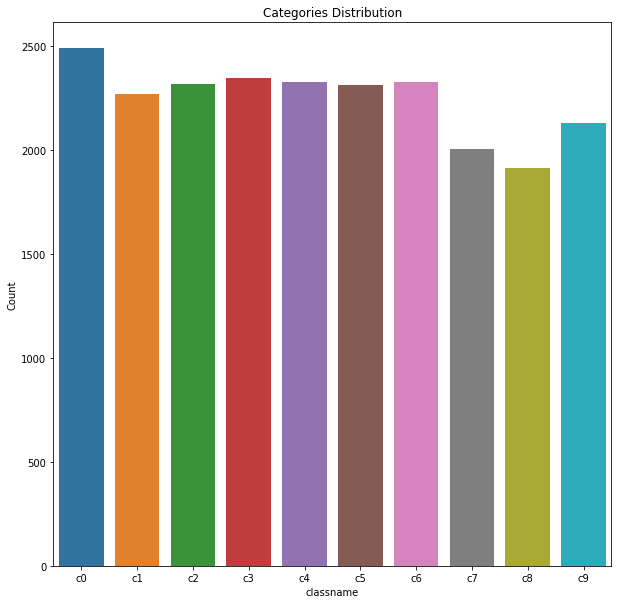

In [23]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [24]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


<Figure size 1440x1440 with 0 Axes>

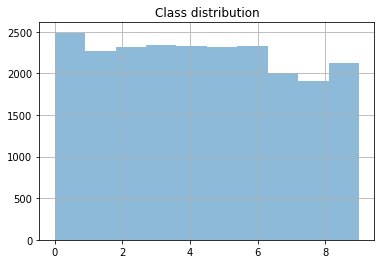

In [25]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

In [26]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

### Create a vanilla CNN model
#### Building the model
 - 4 Convolutional layers
 - A Flatten layer and then 2 Dense layers
 - Optimizer : rmsprop
 - Loss function : categorical_crossentropy

In [16]:
batch_size = 40
nb_epoch = 10

In [17]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [18]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

- ModelCheckpoint : 학습할 때마다 중간중간에 콜백 형태로 알려주고 모델을 저장
   - monitor : loss 값
   - mode : monitor값을 최소화하는 방향으로 학습
   - save_best_only : 최고의 모델 저장
- EarlyStopping : 관찰하는 값이 개선되지 않을 때 stop
   - patience : 몇 epoch가 개선 없이 지나야 학습이 멈추는지 결정하는 epoch 수

In [19]:
def create_model_v1():
    # Vanilla CNN model
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [20]:
model_v1 = create_model_v1()

# More details about the layers
model_v1.summary()

# Compiling the model
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 512)        

- compile : 학습 방식에 대한 환경설정
   - optimizer : rmsprop(Divide	the	gradient by	a running average of its recent magnitude)
     기울기를 단순 누적하지 않고 지수 가중 이동 평균 Exponentially weighted moving average 를 사용하여 최신 기울기들이 더 크게 반영되도록 함.

In [21]:
# Training the Vanilla Model version 1
history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/10
17939/17939 [==============================] - 236s 13ms/step - loss: 3.0043 - accuracy: 0.4691 - val_loss: 0.3497 - val_accuracy: 0.8818

Epoch 00001: val_loss improved from inf to 0.34973, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/10
17939/17939 [==============================] - 231s 13ms/step - loss: 0.3675 - accuracy: 0.8920 - val_loss: 0.2877 - val_accuracy: 0.9298

Epoch 00002: val_loss improved from 0.34973 to 0.28769, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 3/10
17939/17939 [==============================] - 219s 12ms/step - loss: 0.2418 - accuracy: 0.9360 - val_loss: 0.1082 - val_accuracy: 0.9802

Epoch 00003: val_loss improved from 0.28769 to 0.10822, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 4/10
17939/17939 [==============================] - 226s 13ms/step - loss: 0.2302 - accuracy: 0.9456 - val_loss: 0.1466 - val_accuracy: 0.9652

Epoch 00004: val_loss 

- fit : 모델 학습

In [22]:
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')

In [25]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

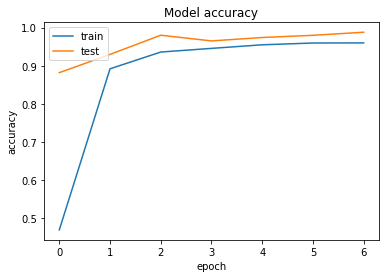

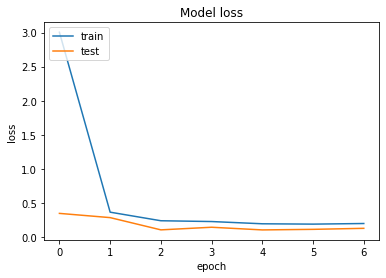

In [26]:
plot_train_history(history_v1)

In [31]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [28]:
score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

4485/4485 [==============================] - 13s 3ms/step
Score:  [0.10742533935925434, 0.9741359949111938]


1/1 [==============================] - 0s 8ms/step
Y prediction: [[8.9142639e-03 1.5874701e-05 3.3964071e-02 2.7080031e-07 8.3936087e-05
  1.1657333e-07 9.5700192e-01 1.9852364e-09 1.9495772e-05 9.6886632e-09]]
Predicted: Drinking


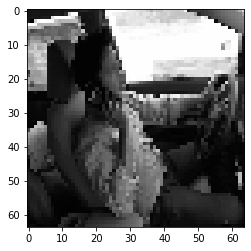

In [32]:
plot_test_class(model_v1, test_files, 20)

In [ ]:
!rm -f saved_models/weights_best_vanilla.hdf5

### Optimised Vanilla CNN Model

In [33]:
def create_model_v2():
    # Optimised Vanilla CNN model
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [34]:
model_v2 = create_model_v2()

# More details about the layers
model_v2.summary()

# Compiling the model
model_v2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 64)       

- BatchNormalization 추가

In [ ]:
# Training the Vanilla Model
history_v2 = model_v2.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

In [ ]:
plot_train_history(history_v2)

In [ ]:
model_v2.load_weights('saved_models/weights_best_vanilla.hdf5')

In [ ]:
score = model_v2.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

y_pred = model_v2.predict(x_test, batch_size=batch_size, verbose=1)
score = log_loss(y_test, y_pred)
print('Score log loss:', score)

In [ ]:
plot_test_class(model_v2, test_files, 101) # The model really performs badly

In [ ]:
plot_test_class(model_v2, test_files, 1) # The model really performs badly

In [ ]:
plot_test_class(model_v2, test_files, 143)

### Create a vanilla CNN model with data augmentation

In [ ]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [ ]:
# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

- ImageDataGenerator : 이미지를 왜곡시켜 텐서 이미지 데이터 배치를 생성
  - rescale: 다른 변형을 전부 적용한 후에 데이터를 주어진 값으로 곱하여 크기 재조절
  - shear_range: 밀림 강도 범위내에서 임의로 원본이미지를 변형. 수치는 시계반대방향으로 밀림 강도를 라디안으로 표현
  - zoom_range: 지정된 확대/축소 범위내에서 임의로 원본이미지를 확대/축소. 0.2라면, 0.8배에서 1.2배 크기 변화
  - horizontal_flip: 수평방향으로 뒤집기
  - validation_split: 검증의 용도로 남겨둘 남겨둘 이미지의 비율

In [35]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
print(nb_train_samples)
print(nb_validation_samples)
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

17939
4485


NameError: name 'train_datagen' is not defined

In [ ]:
checkpoint = ModelCheckpoint('saved_models/weights_best_vanilla.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v3 = model_v2.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples / batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples / batch_size)

- flow
- fit_generator
  - steps_per_epoch: 한 epoch 마다 몇 번 생성기로부터 데이터를 얻을지를 나타내는 값
    한 epoch 마다 사용되는 학습데이터의 수는 steps_per_epoch * batch_size

### 예시

In [ ]:
# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=epochs)

# here's a more "manual" example
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
        model.fit(x_batch, y_batch)
        batches += 1
        if batches >= len(x_train) / 32:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [ ]:
model_v2.load_weights('saved_models/weights_best_vanilla.hdf5')

In [ ]:
plot_train_history(history_v3)

In [ ]:
# Evaluate the performance of the new model
score = model_v2.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plot_test_class(model_v2, test_files, 101)

In [ ]:
predictions = model_v2.predict(test_files, batch_size=batch_size)

In [ ]:
!rm -f saved_models/weights_best_vanilla.hdf5

### Train a CNN with Transfer Learning (VGG, MobileNet)
To reduce training time without sacrificing accuracy, I'll train a CNN using transfer learning.

In [27]:
def vgg_std16_model(img_rows, img_cols, color_type=3):
    nb_classes = 10
    # Remove fully connected layer and replace
    # with softmax for classifying 10 classes
    vgg16_model = VGG16(weights="imagenet", include_top=False)

    # Freeze all layers of the pre-trained model
    for layer in vgg16_model.layers:
        layer.trainable = False
        
    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation = 'softmax')(x)

    model = Model(input = vgg16_model.input, output = predictions)
    
    return model

In [28]:
# Load the VGG16 network
print("Loading network...")
model_vgg16 = vgg_std16_model(img_rows, img_cols)

model_vgg16.summary()

model_vgg16.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

Loading network...
58892288/58889256 [==============================] - 16s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
________________________________________

In [ ]:
training_generator = train_datagen.flow_from_directory('../input/train', 
                                                 target_size = (img_rows, img_cols), 
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical', subset="training")

validation_generator = test_datagen.flow_from_directory('../input/train', 
                                                   target_size = (img_rows, img_cols), 
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")
nb_train_samples = 17943
nb_validation_samples = 4481

In [ ]:
!rm -f saved_models/weights_best_vgg16.hdf5

In [ ]:
# Training the Vanilla Model
checkpoint = ModelCheckpoint('saved_models/weights_best_vgg16.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v4 = model_vgg16.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         class_weight='auto',
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

In [ ]:
model_vgg16.load_weights('saved_models/weights_best_vgg16.hdf5')

In [ ]:
plot_train_history(history_v4)

In [ ]:
def plot_vgg16_test_class(model, test_files, image_number):
    img_brute = test_files[image_number]

    im = cv2.resize(cv2.cvtColor(img_brute, cv2.COLOR_BGR2RGB), (img_rows,img_cols)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)

    img_display = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_display, cmap='gray')

    y_preds = model.predict(im, batch_size=batch_size, verbose=1)
    print(y_preds)
    y_prediction = np.argmax(y_preds)
    print('Y Prediction: {}'.format(y_prediction))
    print('Predicted as: {}'.format(activity_map.get('c{}'.format(y_prediction))))
    
    plt.show()

In [ ]:
plot_vgg16_test_class(model_vgg16, test_files, 133)

In [ ]:
# Evaluate the performance of the new model
score = model_vgg16.evaluate_generator(validation_generator, nb_validation_samples // batch_size, verbose = 1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])